#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project5_end/'

### **(2) 라이브러리 설치 및 불러오기**

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeNormal

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, LSTM, Dense, Dropout, Input, MaxPooling1D
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
def plot_model_result(y_train, y_val, pred):
    # Series로 변환하여 인덱스 재설정
    y_train = pd.Series(y_train).reset_index(drop=True)
    y_val = pd.Series(y_val).reset_index(drop=True)
    pred = pd.Series(pred.reshape(-1)).reset_index(drop=True)

    # 전체 시각화
    plt.figure(figsize=(20, 12))

    # Train, Val, Pred 그래프
    plt.subplot(2, 1, 1)
    plt.plot(y_train, label='train')
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val, label='val')
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), pred, label='pred')
    plt.legend()
    plt.grid()

    # Val, Pred 상세 비교
    plt.subplot(2, 1, 2)
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), y_val, label='val')
    plt.plot(range(len(y_train), len(y_train) + len(y_val)), pred, label='pred')
    plt.legend()
    plt.grid()

    plt.show()


In [6]:
# 한글깨짐방지
# 세션 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (17.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123629 files and direc

In [7]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

In [8]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

### **(3) 데이터 불러오기**

In [9]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [10]:
import pandas as pd

def get_season(date):
  """
  날짜를 받아 계절 정보를 반환하는 함수.
  봄: 0, 여름: 1, 가을: 2, 겨울: 3
  """
  if date.month in [3, 4, 5]:
    return 0
  elif date.month in [6, 7, 8]:
    return 1
  elif date.month in [9, 10, 11]:
    return 2
  else:
    return 3

def preprocess_data(Store_ID=None, Product_ID=None):
  """
  주어진 판매 데이터(sales)를 전처리하여 추가적인 피처를 생성하는 함수.
  특정 Store_ID, Product_ID 기준으로 데이터를 필터링 가능.

  Parameters:
      - Store_ID: 특정 매장(Store)의 ID
      - Product_ID: 특정 상품(Product)의 ID

  Returns:
      - pre_data: 전처리 및 피처 생성이 완료된 데이터프레임
  """
  # 판매 데이터 복사
  sell = sales.copy()

  # 시간 관련 파생 변수 추가
  sell['Weekday'] = sell['Date'].dt.weekday  # 요일
  sell['YearMonth'] = sell['Date'].dt.to_period('M')  # 연-월
  sell['Month'] = sell['Date'].dt.month  # 월
  sell['Season'] = sell['Date'].apply(get_season)  # 계절

  # 유가 데이터 복사
  oil = oil_price.copy()

  # 데이터 병합
  sell_products = sell.merge(products, on='Product_ID', how='left')
  sell_orders = sell_products.merge(orders, on=['Date', 'Store_ID'], how='left')
  sell_oil = sell_orders.merge(oil, on='Date', how='left')
  pre_data = sell_oil.merge(stores, on='Store_ID', how='left')

  # 결측치 처리: 방문자 수
  pre_data['CustomerCount'] = pre_data.groupby(['YearMonth', 'Weekday'])['CustomerCount'].transform(
    lambda x: x.fillna(x.mean().round(0))
  )

  # 동일 지역 방문객 수
  pre_data['City_Visitor_Count'] = pre_data.groupby(['Date', 'City'])['CustomerCount'].transform('sum')

  # 동일 카테고리 판매량 합계
  pre_data['Category_Sales_Sum'] = pre_data.groupby(['Date', 'Category'])['Qty'].transform('sum')

  # 7일, 30일 판매량 이동 평균
  pre_data['Qty_MA_7'] = pre_data.groupby('Store_ID')['Qty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
  pre_data['Qty_MA_30'] = pre_data.groupby('Store_ID')['Qty'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

  # 7일 방문자 수 이동 평균
  pre_data['CustomerCount_MA_7'] = pre_data.groupby('Store_ID')['CustomerCount'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

  # WTI 120일 이동 평균
  pre_data['WTI_Price'] = pre_data['WTI_Price'].fillna(method='ffill').fillna(method='bfill')

  pre_data['WTI_Price_MA_30'] = pre_data['WTI_Price'].rolling(window=120, min_periods=1).mean()

  # 2014-01-01 데이터 제거
  pre_data = pre_data[pre_data['Date'] != '2014-01-01']

  # Target 생성: LeadTime 뒤 판매량을 타겟으로 설정
  pre_data['target'] = pre_data.groupby(['Store_ID', 'Product_ID']).apply(
    lambda group: group['Qty'].shift(-group['LeadTime'].iloc[0]) if group['LeadTime'].notna().all() else None
  ).reset_index(level=[0, 1], drop=True)

  # 결측치 제거
  pre_data.dropna(inplace=True)

  # 특정 매장 및 상품 필터링
  if Store_ID is not None:
    pre_data = pre_data[pre_data['Store_ID'] == Store_ID]
  if Product_ID is not None:
    pre_data = pre_data[pre_data['Product_ID'] == Product_ID]

  columns_to_drop = ['Product_Code', 'Store_ID', 'Product_ID', 'SubCategory', 'City', 'State', 'Store_Type', 'Category', 'YearMonth', 'LeadTime', 'Price']
  pre_data = pre_data.drop(columns=columns_to_drop, errors='ignore')

  return pre_data

## **(1) 상품 : 3 - Beverage**

In [11]:
Beverage_data = preprocess_data(44, 3)

In [12]:
Beverage_data

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,Qty_MA_30,CustomerCount_MA_7,WTI_Price_MA_30,target
1456,2014-01-02,9853.0,3,1,3,4422.0,95.14,718152.0,176120.0,1414.857143,582.588235,1971.428571,95.14,15153.0
2267,2014-01-03,8647.0,4,1,3,4167.0,93.66,664872.0,151502.0,1544.824429,1310.339067,4385.571429,93.66,15606.0
3078,2014-01-04,15153.0,5,1,3,5341.0,93.66,820006.0,222138.0,2501.242000,1990.612933,4334.714286,93.66,7900.0
3889,2014-01-05,15606.0,6,1,3,5123.0,93.66,771668.0,222012.0,2660.689571,2539.186233,5309.857143,93.66,7188.0
4700,2014-01-06,7900.0,0,1,3,3917.0,93.12,614642.0,136433.0,1466.173857,2566.260433,4950.714286,93.12,8800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929243,2017-02-22,7856.0,2,2,3,3834.0,53.61,583929.0,152398.0,1334.745857,1364.646033,3437.142857,53.61,10208.0
930054,2017-02-23,8018.0,3,2,3,3955.0,54.48,602170.0,154467.0,1355.756000,1491.900633,3851.285714,54.48,12361.0
930865,2017-02-24,10208.0,4,2,3,4549.0,53.99,652099.0,191870.0,1688.727428,1635.479100,4039.857143,53.99,10108.0
931676,2017-02-25,12361.0,5,2,3,4619.0,53.99,706634.0,245661.0,2147.614714,1907.937833,4559.000000,53.99,10006.0


In [13]:
Beverage_data[Beverage_data['target'] == 0]

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,Qty_MA_30,CustomerCount_MA_7,WTI_Price_MA_30,target
294228,2014-12-30,9218.0,1,12,3,5745.0,54.14,890370.0,204462.0,1599.809144,1722.554637,4993.285714,54.14,0.0
589433,2015-12-30,11025.0,2,12,3,5938.0,36.59,879523.0,228998.0,1882.913714,1840.113800,5256.571429,36.59,0.0
885449,2016-12-30,13050.0,4,12,3,6360.0,53.75,942330.0,261907.0,2178.928429,2100.383700,5024.571429,53.75,0.0


## **(2) 상품 : 12 - Milk**

In [14]:
Milk_data = preprocess_data(44, 12)

In [15]:
Milk_data

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,Qty_MA_30,CustomerCount_MA_7,WTI_Price_MA_30,target
1462,2014-01-02,9647.0,3,1,3,4422.0,95.14,718152.0,298620.320011,4050.771571,1235.060913,4422.0,95.14,14188.0
2273,2014-01-03,8879.0,4,1,3,4167.0,93.66,664872.0,250953.870948,3685.427429,1882.038800,4167.0,93.66,14490.0
3084,2014-01-04,14188.0,5,1,3,5341.0,93.66,820006.0,352348.306930,6007.732571,2417.386167,5341.0,93.66,7614.0
3895,2014-01-05,14490.0,6,1,3,5123.0,93.66,771668.0,362852.115984,6129.631571,3015.869000,5123.0,93.66,7124.0
4706,2014-01-06,7614.0,0,1,3,3917.0,93.12,614642.0,233749.026011,3198.731857,2360.386267,3917.0,93.12,8683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929249,2017-02-22,8931.0,2,2,3,3834.0,53.61,583929.0,291531.818032,3351.534571,1554.875767,3834.0,53.61,10630.0
930060,2017-02-23,8643.0,3,2,3,3955.0,54.48,602170.0,275729.049108,3331.844571,1663.538900,3955.0,54.48,12978.0
930871,2017-02-24,10630.0,4,2,3,4549.0,53.99,652099.0,321725.645966,4078.860000,1839.377200,4549.0,53.99,10899.0
931682,2017-02-25,12978.0,5,2,3,4619.0,53.99,706634.0,416027.184840,4986.601714,2266.687567,4619.0,53.99,10618.0


## **(3) 상품 : 42 - Agricultural products**

In [16]:
Agricultural_products_data = preprocess_data(44, 42)

In [17]:
Agricultural_products_data

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,Qty_MA_30,CustomerCount_MA_7,WTI_Price_MA_30,target
1469,2014-01-02,76.0,3,1,3,4422.0,95.14,718152.0,35336.643958,211.092000,996.134833,4422.0,95.14,78.0
2280,2014-01-03,74.0,4,1,3,4167.0,93.66,664872.0,32032.468719,265.986871,1942.402403,4167.0,93.66,88.0
3091,2014-01-04,78.0,5,1,3,5341.0,93.66,820006.0,34557.982838,318.666571,2419.149333,5341.0,93.66,65.0
3902,2014-01-05,88.0,6,1,3,5123.0,93.66,771668.0,29491.302000,202.362143,2984.330367,5123.0,93.66,78.0
4713,2014-01-06,65.0,0,1,3,3917.0,93.12,614642.0,18564.406008,128.875567,2289.229666,3917.0,93.12,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929256,2017-02-22,72.0,2,2,3,3834.0,53.61,583929.0,24724.948041,160.245571,1550.144667,3834.0,53.61,91.0
930067,2017-02-23,98.0,3,2,3,3955.0,54.48,602170.0,27044.175066,183.132714,1656.362500,3955.0,54.48,105.0
930878,2017-02-24,91.0,4,2,3,4549.0,53.99,652099.0,38533.122986,328.836571,1866.696000,4549.0,53.99,108.0
931689,2017-02-25,105.0,5,2,3,4619.0,53.99,706634.0,33742.627958,341.363000,2291.702533,4619.0,53.99,78.0


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [18]:

def data_pre(data, y_scale=True):
  """
  데이터 전처리 함수:
  1. Weekday, Month, Season 원핫 인코딩
  2. 나머지 수치형 컬럼 스케일링
  3. 데이터를 학습용, 검증용으로 분할
  Parameters:
    - data: data프레임
    - y_scale: y 스케일링 여부

  Returns:
    - x_train: 학습용 데이터의 입력값
    - x_val: 검증용 데이터의 입력값
    - y_train: 학습용 데이터의 타겟 값
    - y_val: 검증용 데이터의 타겟 값
    - scaler: 같은 스케일링을 적용하거나 역변환에 사용
    - y_min: 타겟 변수 최소값
    - y_max: 타겟 변수 최대값
  """

  target = 'target'
  x = data.drop(['Date', target], axis=1)
  y = data.loc[:, target]

  # 원핫 인코딩
  categorical_features = ['Weekday', 'Month', 'Season']
  encoder = OneHotEncoder(sparse_output=False, drop='first')
  encoded_categorical = encoder.fit_transform(x[categorical_features])
  encoded_columns = encoder.get_feature_names_out(categorical_features)

  # 원핫 인코딩 결과 데이터프레임
  encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns, index=x.index)

  # 원핫 인코딩 적용 후 나머지 수치형 데이터 병합
  numeric_features = x.drop(categorical_features, axis=1)
  x_processed = pd.concat([numeric_features, encoded_df], axis=1)

  # 스케일링
  scaler = MinMaxScaler()
  x_scaled = scaler.fit_transform(x_processed)

  # y 스케일링
  if y_scale:
    y_min, y_max = y.min(), y.max()
    y_scaled = (y - y_min) / (y_max - y_min)
  else:
    y_min, y_max = np.nan, np.nan
    y_scaled = y

  # 데이터 분할
  x_train, x_val, y_train, y_val = train_test_split(x_scaled, y_scaled, test_size=60, shuffle=False)

  return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [19]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre(Beverage_data, True)

In [20]:
clear_session()

nfeat = x_train.shape[1]

model_beverage = Sequential([Dense(1, input_shape = (nfeat, ) )])
model_beverage.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

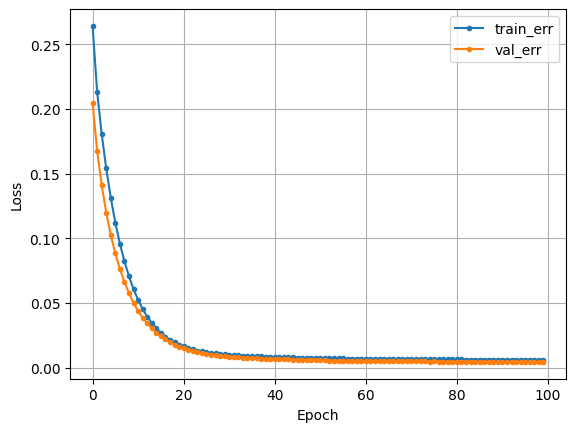

In [21]:
model_beverage.compile(optimizer = 'adam', loss = 'mse')
hist = model_beverage.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [22]:
pred = model_beverage.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE :  2597.24525197347
MAPE :  1.1834062707954637e+18
R2 :  0.03560628513001263


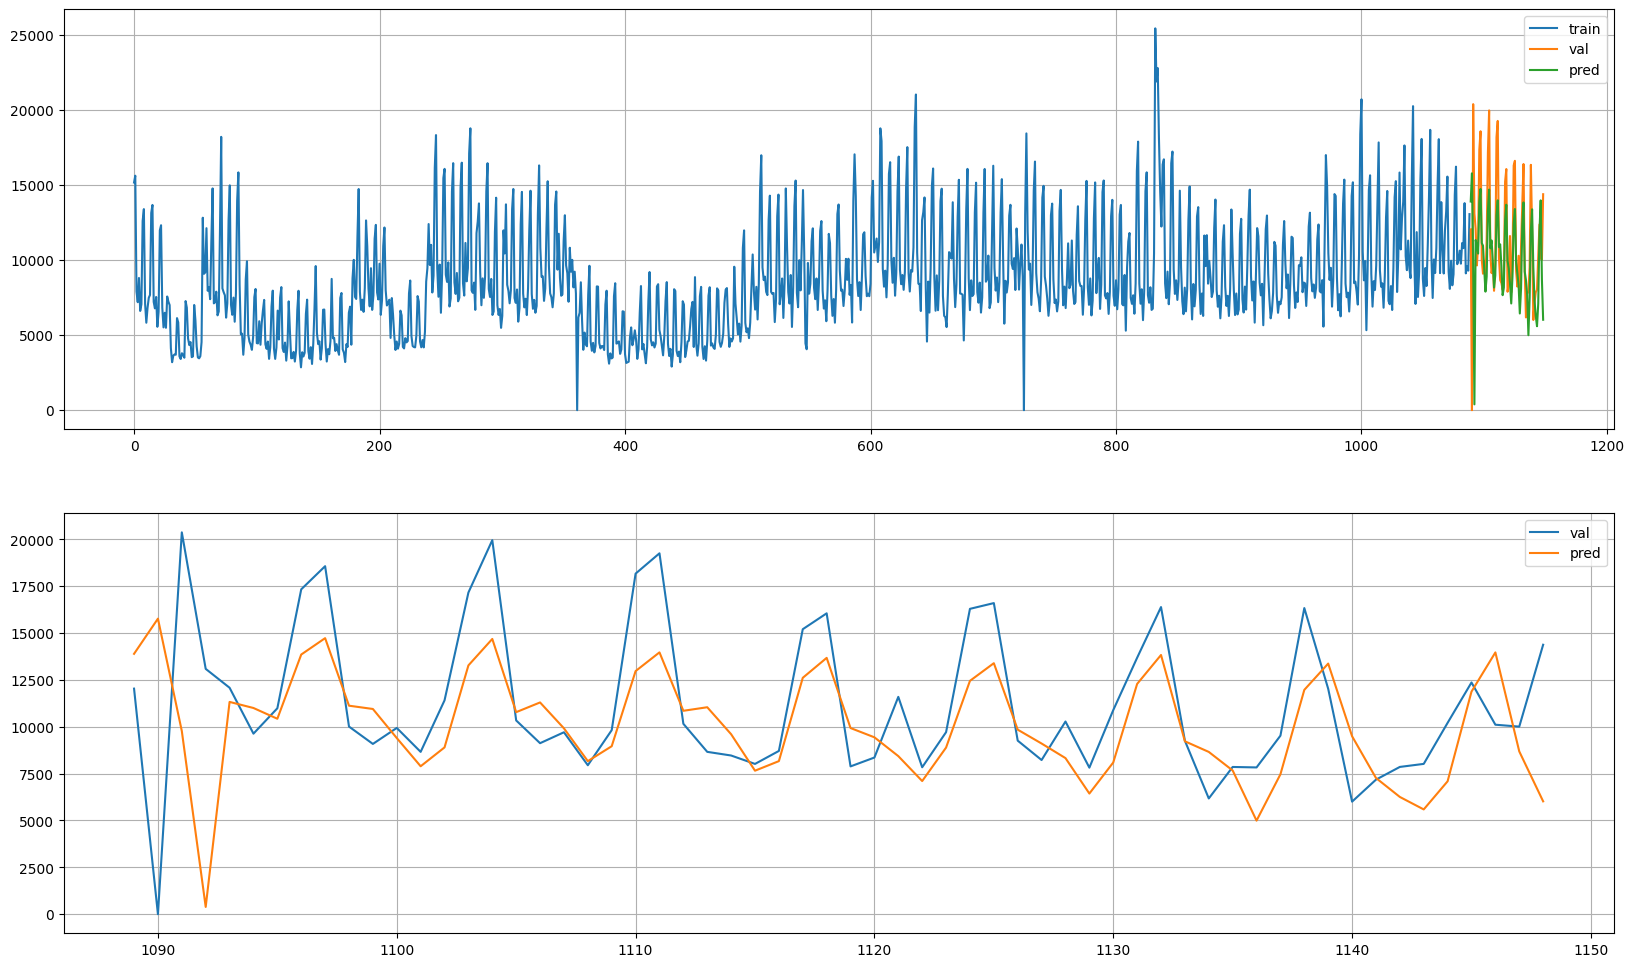

In [23]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [24]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre(Milk_data, True)

In [25]:
clear_session()

nfeat = x_train.shape[1]

model_milk = Sequential([Dense(1, input_shape = (nfeat, ) )])
model_milk.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

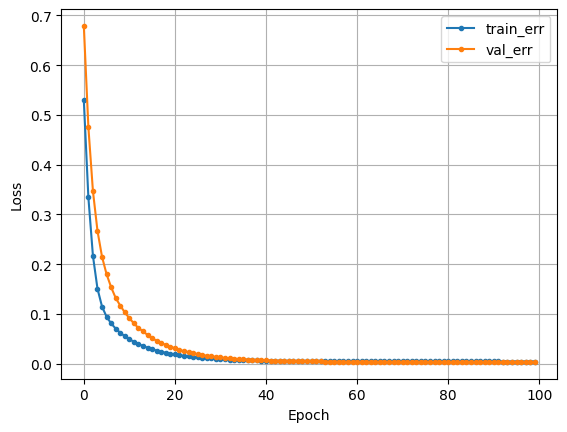

In [26]:
model_milk.compile(optimizer = 'adam', loss = 'mse')
hist = model_milk.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [27]:
pred = model_milk.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MAE :  2405.205330403646
MAPE :  1.301431660561249e+18
R2 :  -0.00509312827947439


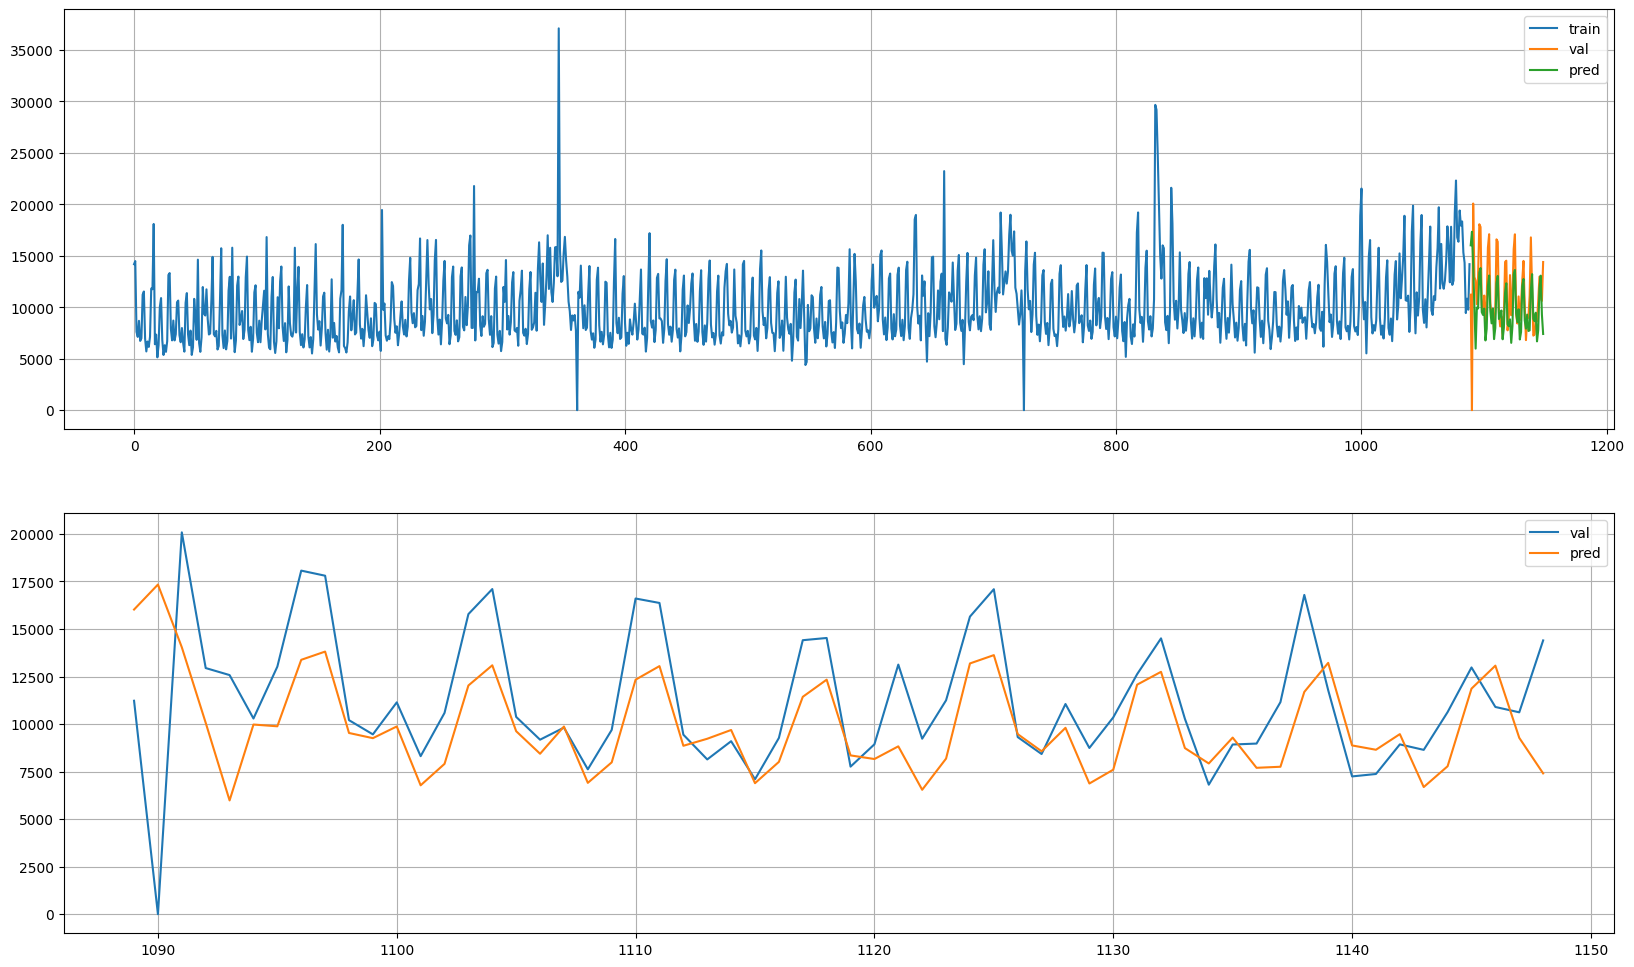

In [28]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [44]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre(Agricultural_products_data, True)

In [45]:
clear_session()

nfeat = x_train.shape[1]

model_agricultural_products = Sequential([Dense(1, input_shape = (nfeat, ) )])
model_agricultural_products.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30 (120.00 B)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 0 (0.00 B)

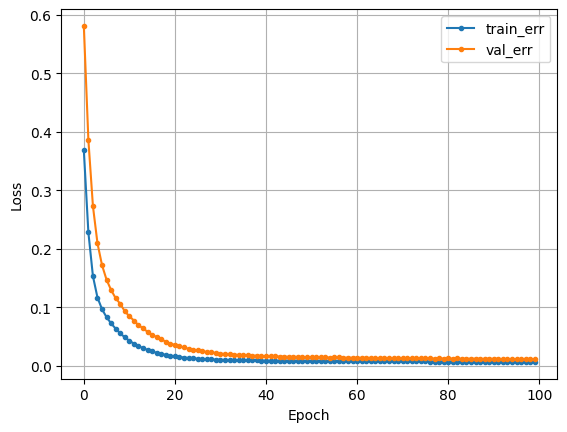

In [46]:
model_agricultural_products.compile(optimizer = 'adam', loss = 'mse')
hist = model_agricultural_products.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [47]:
pred = model_agricultural_products.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
MAE :  9.536473019917805
MAPE :  0.10652808264794504
R2 :  0.11898217429012892


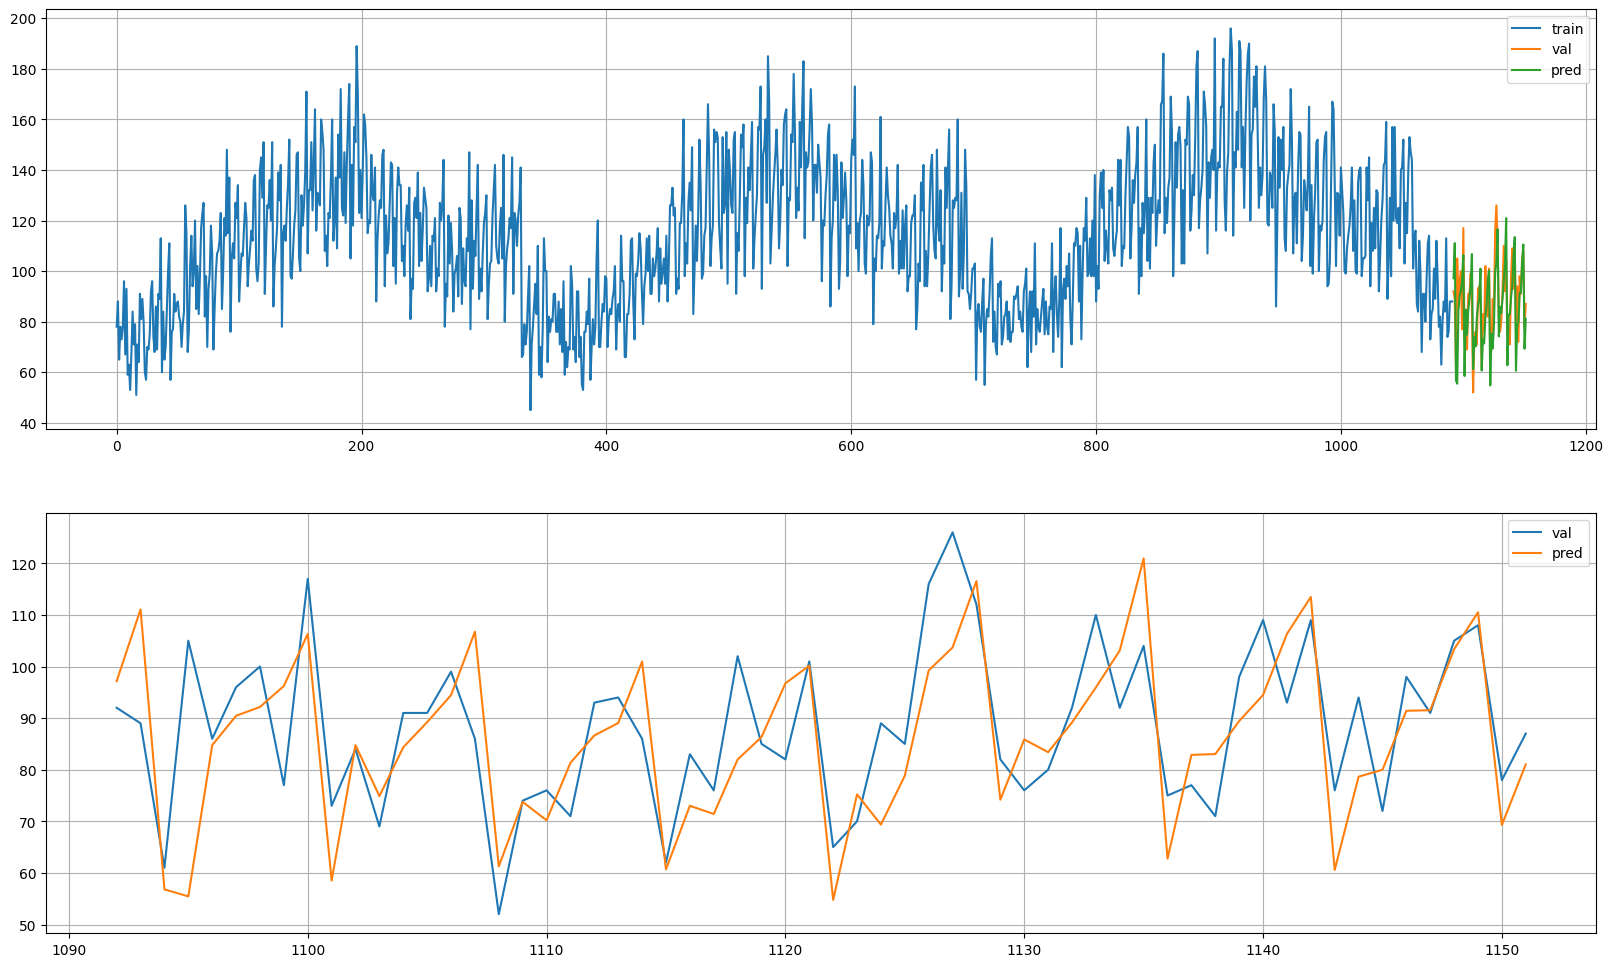

In [33]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [34]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [35]:
def data_pre_lstm(data, timesteps=10, y_scale=True):
    """
    데이터 전처리 함수 (LSTM용):
    1. Weekday, Month, Season 원핫 인코딩
    2. 나머지 수치형 컬럼 스케일링
    3. 데이터를 시계열 형식으로 변환
    4. 학습용, 검증용 데이터로 분할

    Parameters:
        - data: 데이터프레임
        - timesteps: 시계열 데이터를 생성할 timestep 수
        - y_scale: y 스케일링 여부

    Returns:
        - x_train: 학습용 데이터의 입력값 (시계열 형식)
        - x_val: 검증용 데이터의 입력값 (시계열 형식)
        - y_train: 학습용 데이터의 타겟 값
        - y_val: 검증용 데이터의 타겟 값
        - scaler: 같은 스케일링을 적용하거나 역변환에 사용
        - y_min: 타겟 변수 최소값
        - y_max: 타겟 변수 최대값
    """

    target = 'target'
    x = data.drop(['Date', target], axis=1)
    y = data.loc[:, target]

    # 원핫 인코딩
    categorical_features = ['Weekday', 'Month', 'Season']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_categorical = encoder.fit_transform(x[categorical_features])
    encoded_columns = encoder.get_feature_names_out(categorical_features)

    # 원핫 인코딩 결과 데이터프레임
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns, index=x.index)

    # 원핫 인코딩 적용 후 나머지 수치형 데이터 병합
    numeric_features = x.drop(categorical_features, axis=1)
    x_processed = pd.concat([numeric_features, encoded_df], axis=1)

    # 스케일링
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x_processed)

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan
        y_scaled = y

    # 시계열 데이터 변환
    x_scaled = pd.DataFrame(x_scaled, index=x.index)
    x_seq, y_seq = temporalize(x_scaled, pd.Series(y_scaled), timesteps)

    # 데이터 분할
    x_train, x_val, y_train, y_val = train_test_split(x_seq, y_seq, test_size=120, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [77]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Beverage_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1023, 7, 29), (120, 7, 29))

* **모델링**

In [89]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_beverage = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

model03_beverage.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          80,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,833 (511.07 KB)

 Trainable params: 130,833 (511.07 KB)

 Non-trainable params: 0 (0.00 B)

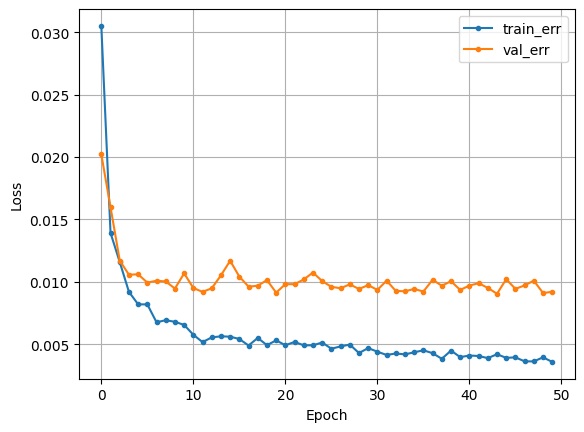

In [90]:
model03_beverage.compile(optimizer = 'adam', loss = 'mse')
hist = model03_beverage.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [92]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_beverage.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
MAE :  1945.316357421875
MAPE :  3.813435812111625e+17
R2 :  0.43928200264160533


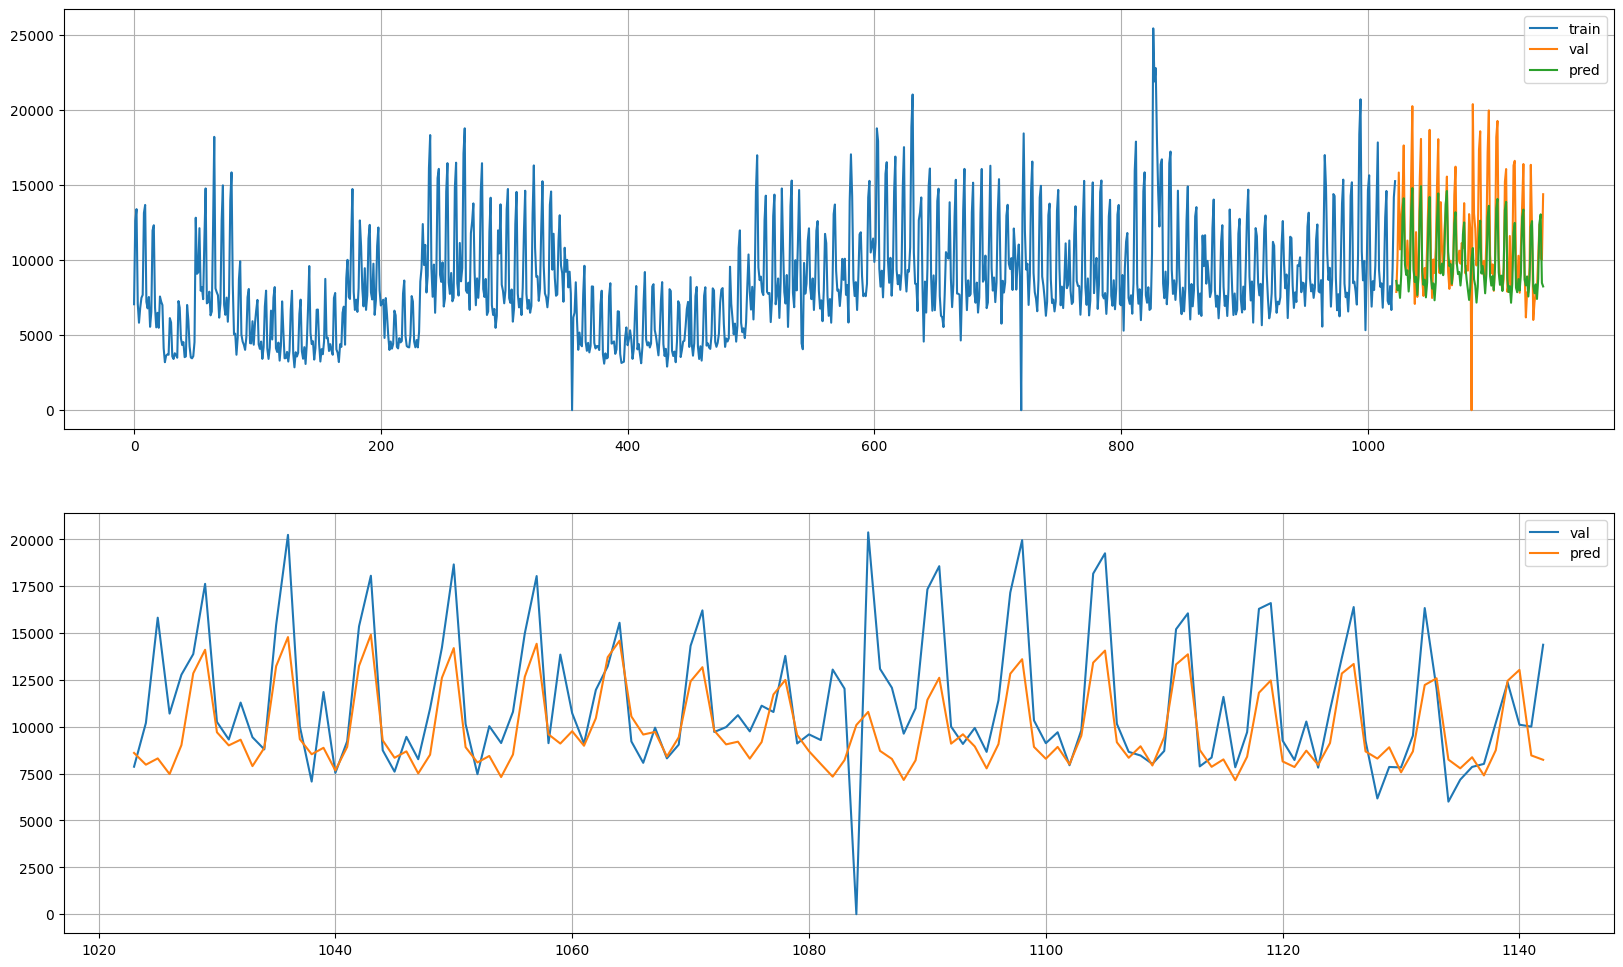

In [91]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [93]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Milk_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (1023, 7, 29), (120, 7, 29))

* **모델링**

In [94]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_milk = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

model03_milk.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          80,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,833 (511.07 KB)

 Trainable params: 130,833 (511.07 KB)

 Non-trainable params: 0 (0.00 B)

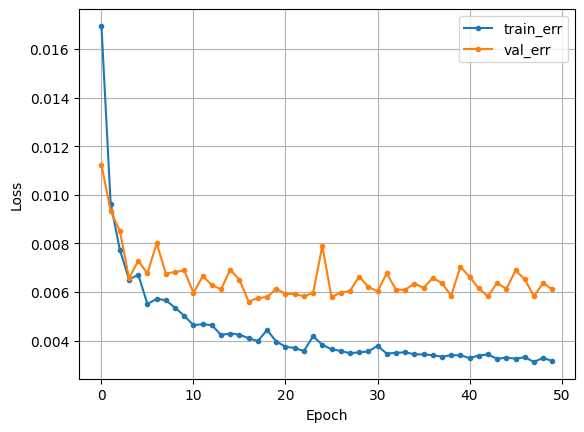

In [95]:
model03_milk.compile(optimizer = 'adam', loss = 'mse')
hist = model03_milk.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [96]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_milk.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
MAE :  2195.1827026367187
MAPE :  4.427306348038499e+17
R2 :  0.4178141924445765


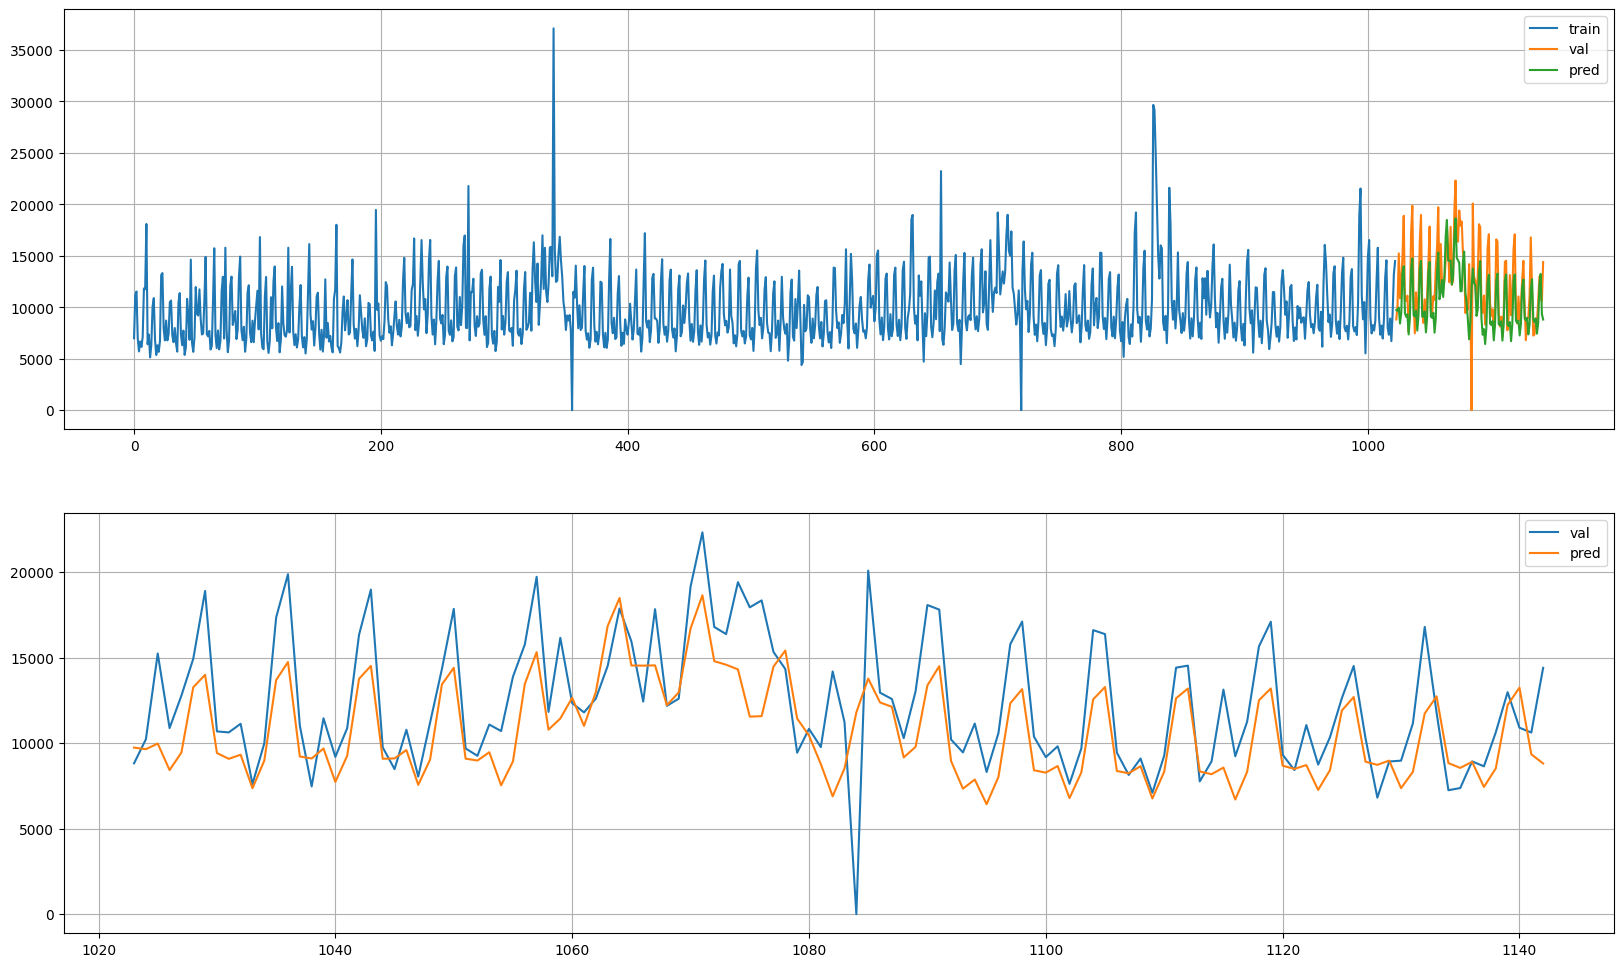

In [97]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [98]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Agricultural_products_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1026, 7, 29), (120, 7, 29))

* **모델링**

In [99]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_agricultural_products = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model03_agricultural_products.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          80,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,833 (511.07 KB)

 Trainable params: 130,833 (511.07 KB)

 Non-trainable params: 0 (0.00 B)

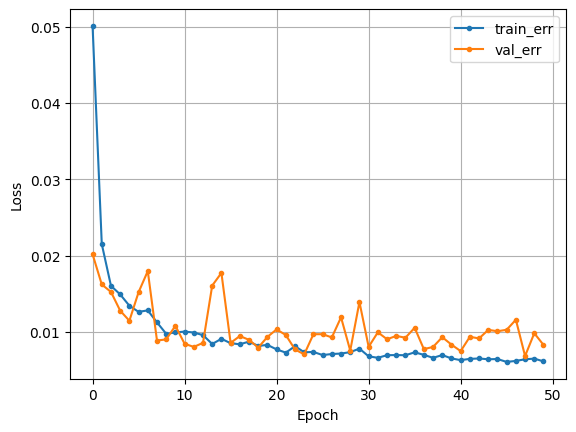

In [100]:
model03_agricultural_products.compile(optimizer = 'adam', loss = 'mse')
hist = model03_agricultural_products.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [101]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_agricultural_products.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
MAE :  10.674533589680989
MAPE :  0.10635216501893388
R2 :  0.6618282314856652


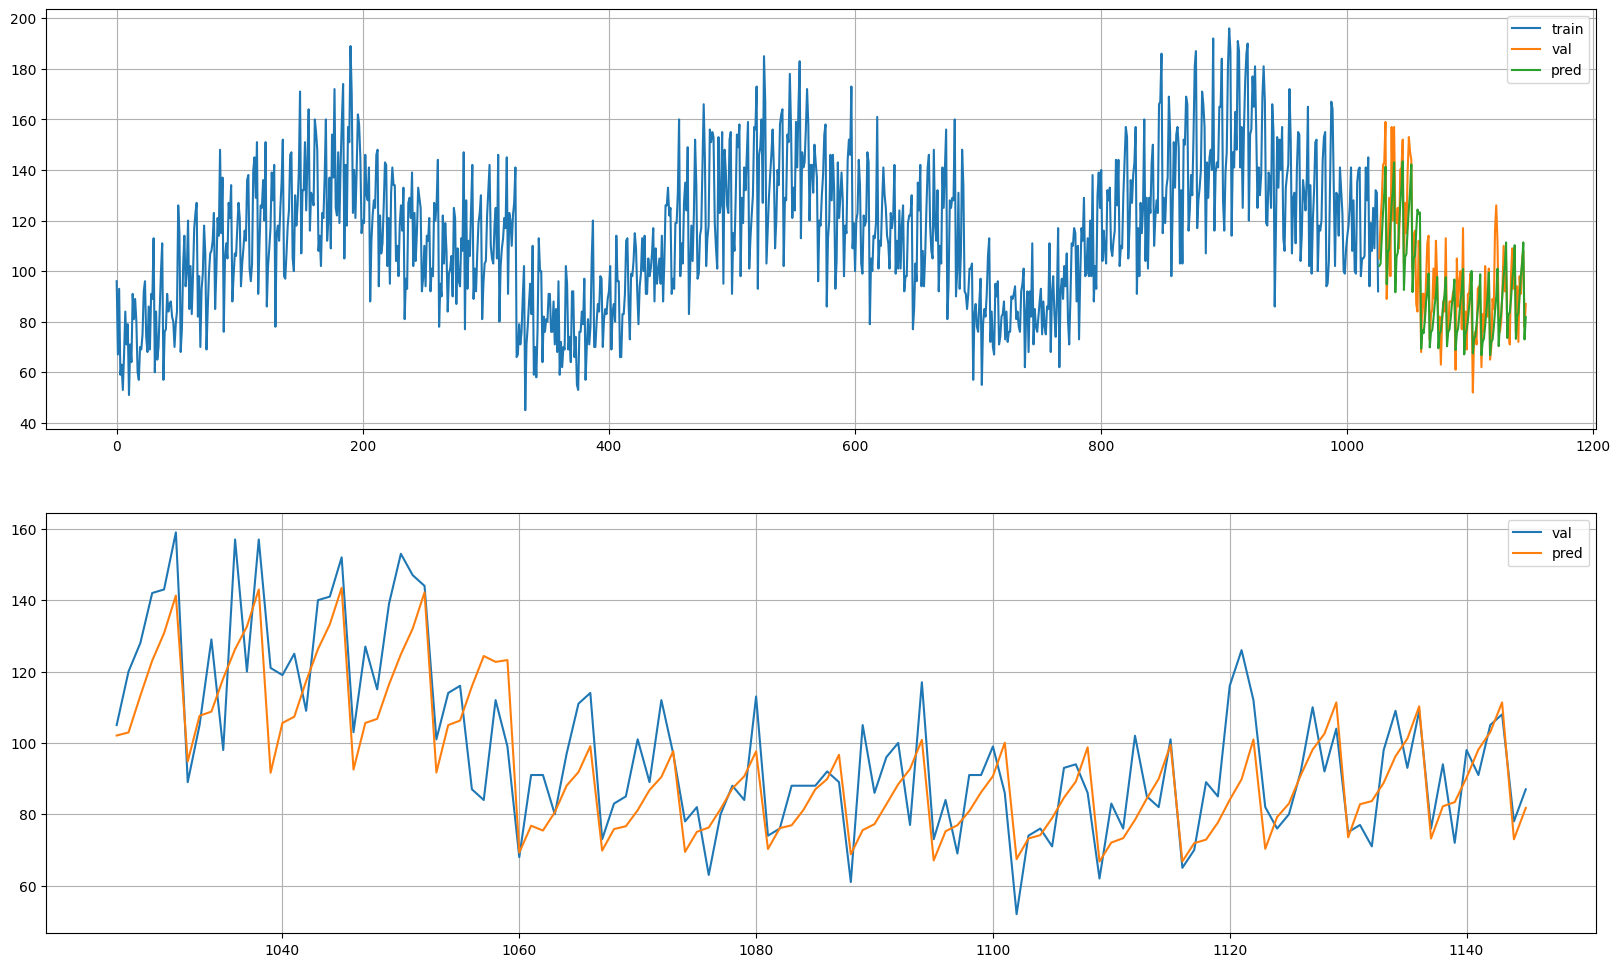

In [102]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [155]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Beverage_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1023, 7, 29), (120, 7, 29))

* **모델링**

In [156]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_beverage_c = Sequential([
  Conv1D(16, 3, input_shape=(timesteps, nfeat), activation='relu', padding='same'),
  Dropout(0.2),
  Conv1D(32, 3, activation='relu', padding='same'),
  Dropout(0.2),
  Flatten(),
  Dense(16, activation='relu'),
  Dropout(0.3),
  Dense(1, activation='linear')
])
model03_beverage_c.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

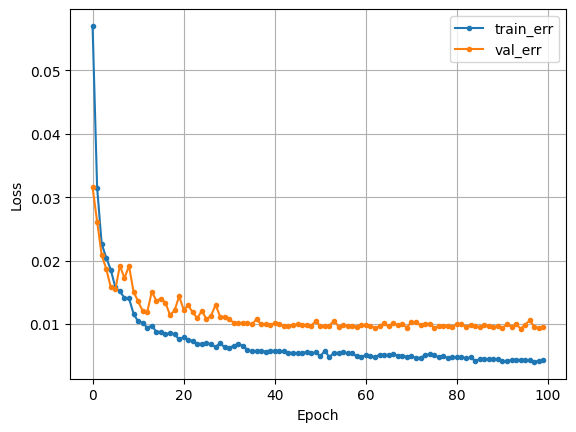

In [157]:
model03_beverage_c.compile(optimizer = 'adam', loss = 'mse')
hist = model03_beverage_c.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [158]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_beverage_c.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE :  2357.166394042969
MAPE :  4.778399468988924e+17
R2 :  0.25973714457284436


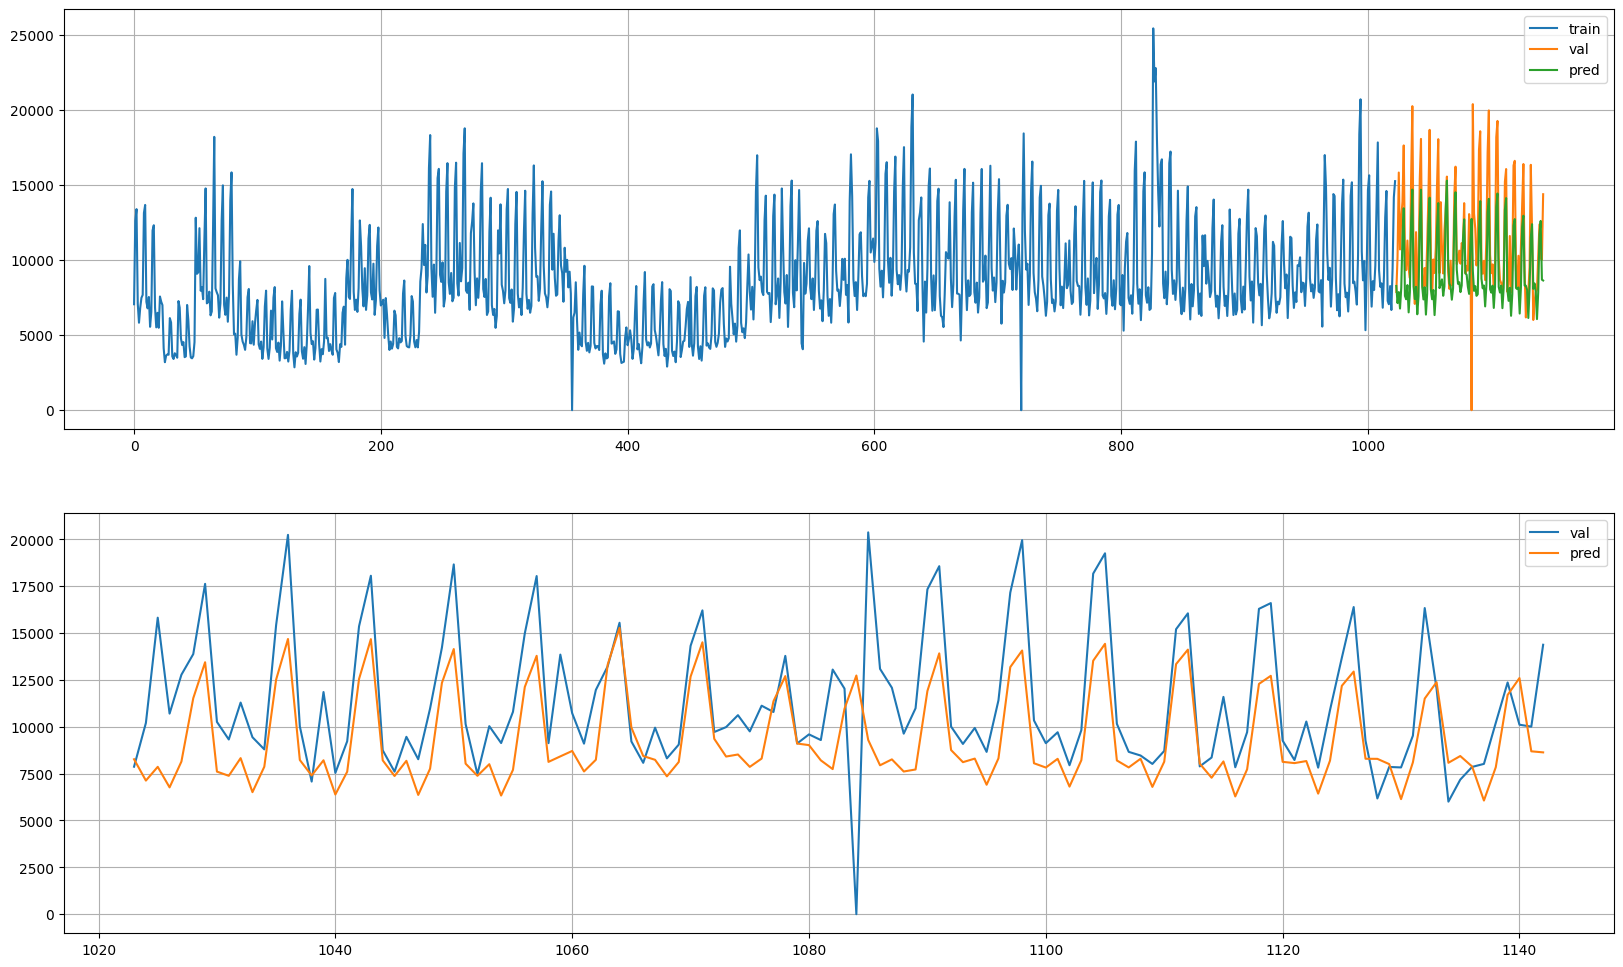

In [159]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [117]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Milk_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 37106.0, (1023, 7, 29), (120, 7, 29))

* **모델링**

In [127]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_milk_c = Sequential([
  Conv1D(16, 3, input_shape=(timesteps, nfeat), activation='relu', padding='same'),
  Dropout(0.3),
  Conv1D(32, 3, activation='relu', padding='same'),
  Dropout(0.3),
  Flatten(),
  Dense(16, activation='relu'),
  Dropout(0.4),
  Dense(1, activation='linear')
])
model03_milk_c.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

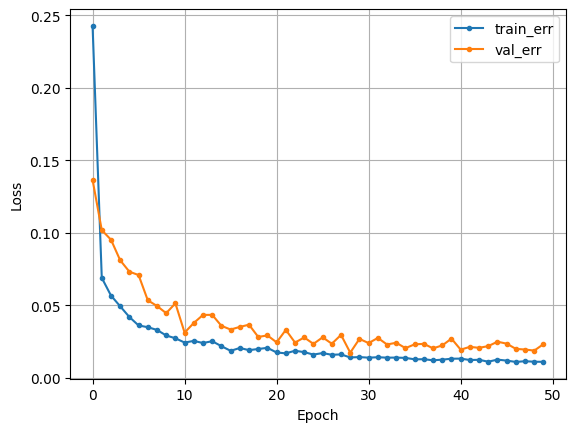

In [128]:
model03_milk_c.compile(optimizer = 'adam', loss = 'mse')
hist = model03_milk_c.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [129]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_milk_c.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE :  12.015565617879231
MAPE :  0.11796038933364701
R2 :  0.5527792098100492


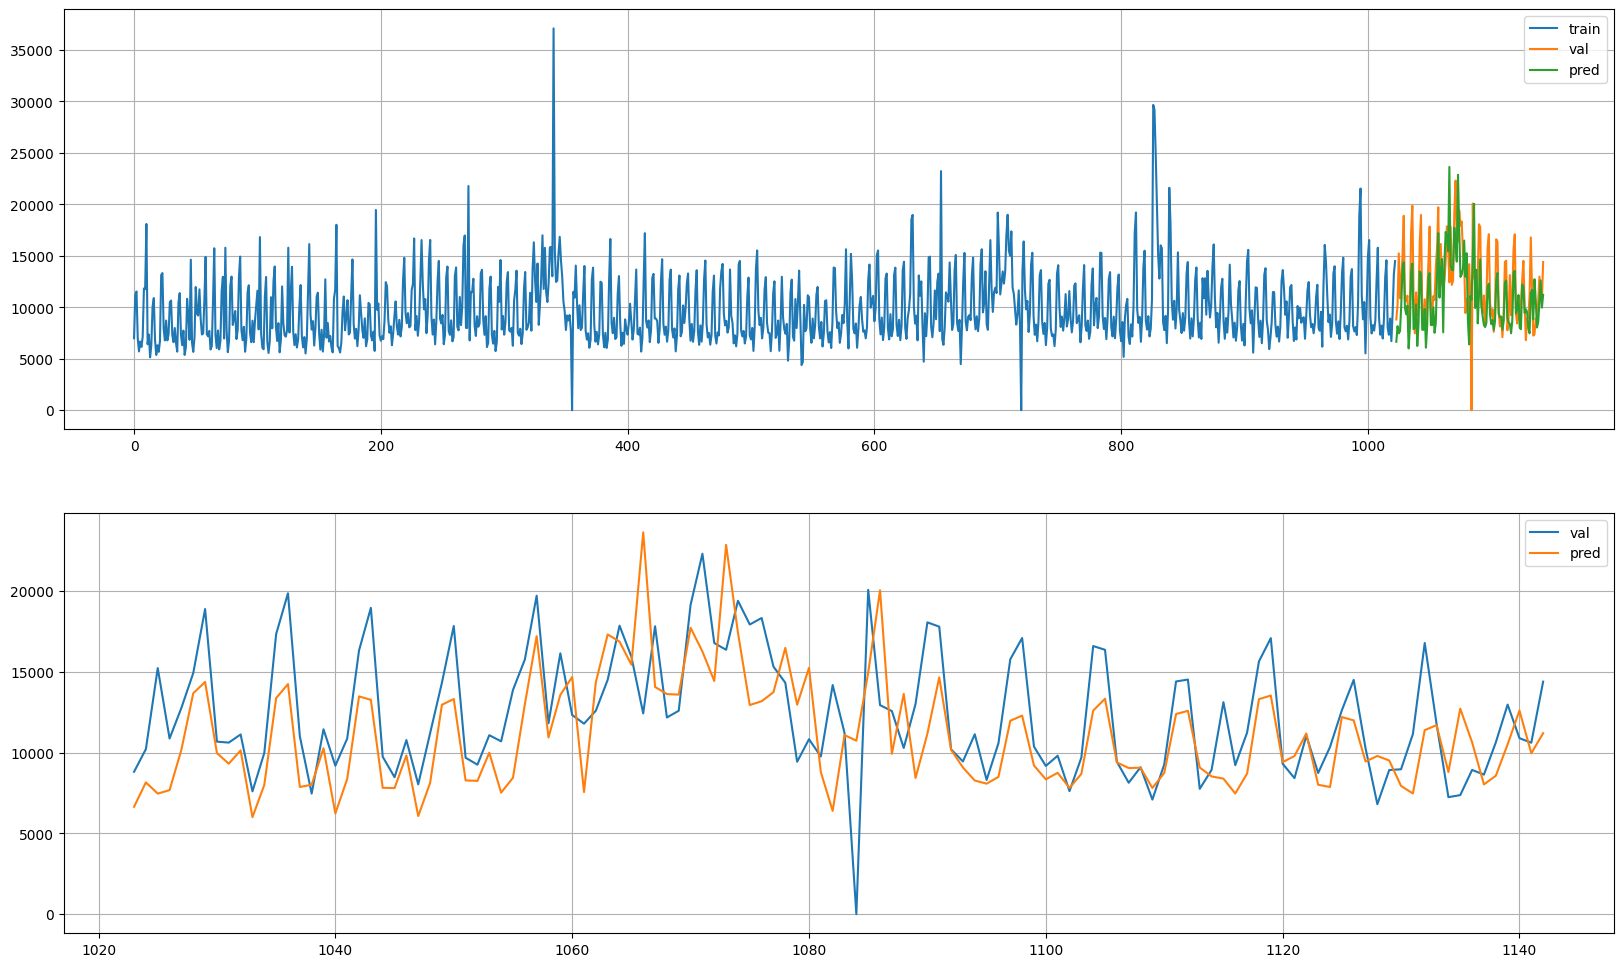

In [121]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [169]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Agricultural_products_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1026, 7, 29), (120, 7, 29))

* **모델링**

In [170]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_agricultural_products_c = Sequential([
  Conv1D(16, 3, input_shape=(timesteps, nfeat), activation='relu', padding='same'),
  Dropout(0.3),
  Conv1D(32, 3, activation='relu', padding='same'),
  Dropout(0.3),
  Flatten(),
  Dense(16, activation='relu'),
  Dropout(0.3),
  Dense(1, activation='linear')
])
model03_agricultural_products_c.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 16)               │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 7, 32)               │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,593 (25.75 KB)

 Trainable params: 6,593 (25.75 KB)

 Non-trainable params: 0 (0.00 B)

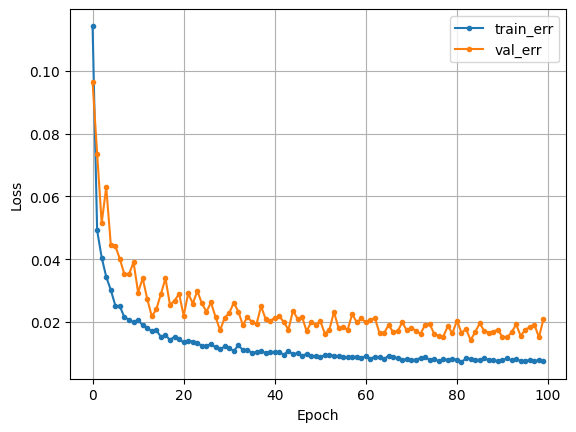

In [166]:
model03_agricultural_products_c.compile(optimizer = 'adam', loss = 'mse')
hist = model03_agricultural_products_c.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [167]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_agricultural_products_c.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE :  11.647966766357422
MAPE :  0.11425653308296371
R2 :  0.5771026273407559


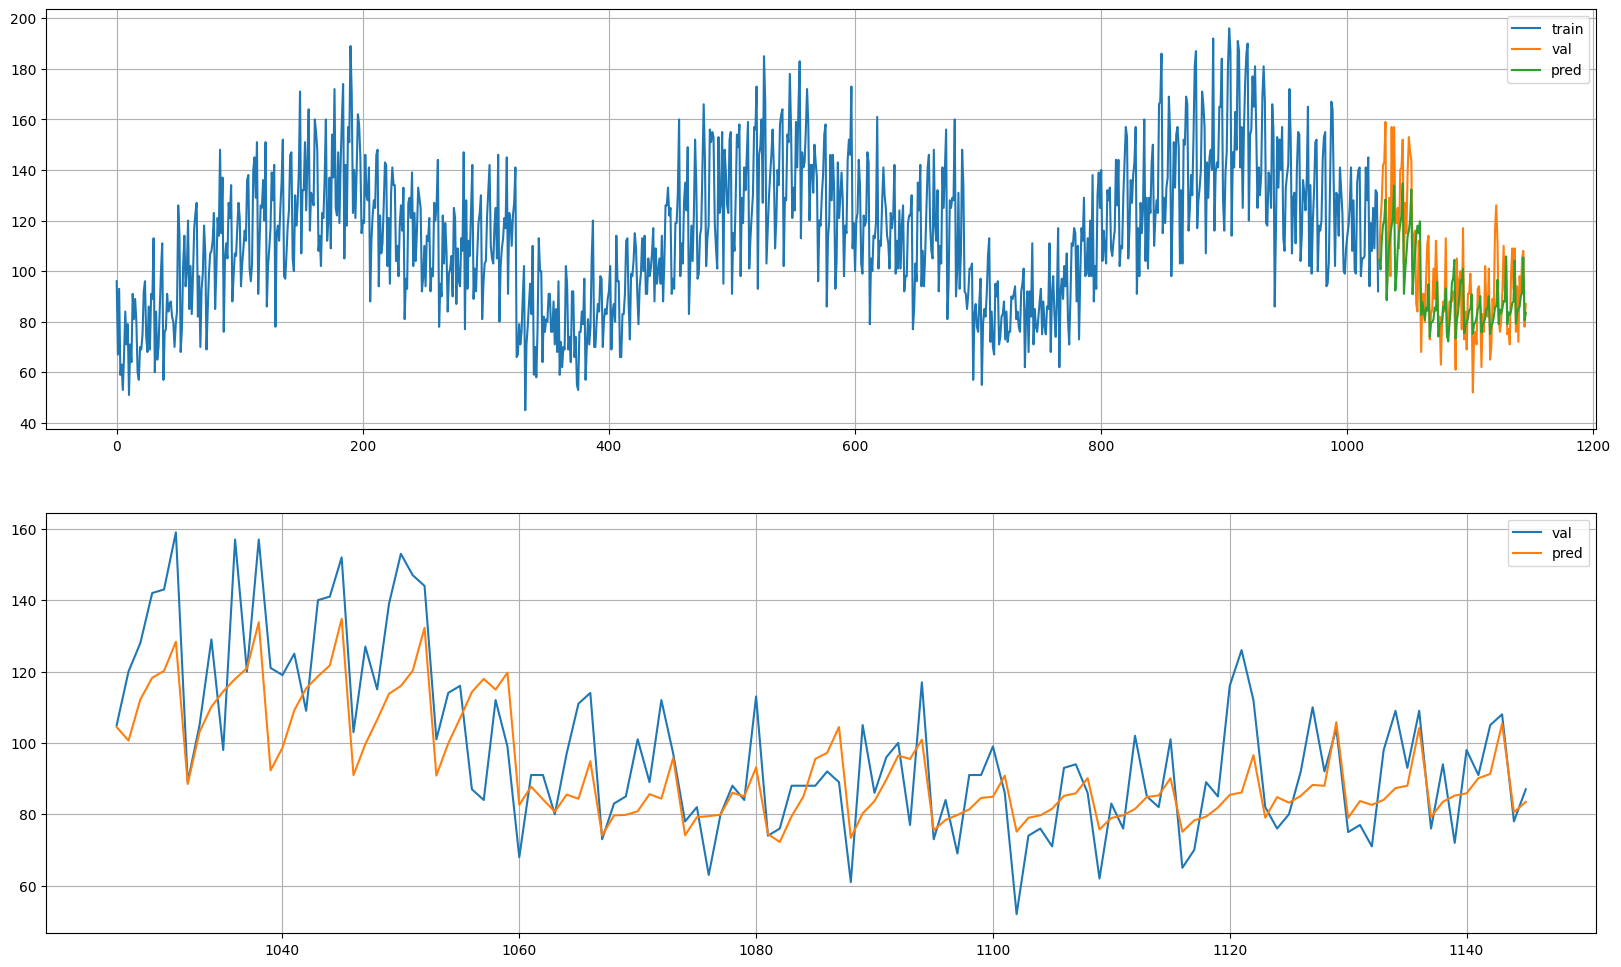

In [168]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
import joblib

# 파일을 저장할 경로 및 파일 이름 지정
file_path = 'Beverage_data.pkl'

# .pkl 파일로 Beverage_data 데이터셋 저장
joblib.dump(Beverage_data, file_path)

In [ ]:
import joblib

# 파일을 저장할 경로 및 파일 이름 지정
file_path = 'Milk_data.pkl'

# .pkl 파일로 Beverage_data 데이터셋 저장
joblib.dump(Milk_data, file_path)